In [124]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise, auc, roc_curve
from sklearn.preprocessing import normalize
import numpy as np, pandas as pd, scipy.sparse as sparse
from matplotlib import pyplot as plt, font_manager as mfm, os
import sys 
sys.path.append('..')
import helpers

In [60]:
train_row = 5000
validate_row = 5348
label_prefix = '__label__'

In [61]:
article_contents = pd.read_parquet('../datasets/uci_news.snappy.parquet')
article_contents = article_contents.iloc[0:train_row + validate_row].sample(frac=1)
article_contents.head()

,article_id,title,url,publisher,category,story,hostname,timestamp,main_content,main_content_len,category_publish_name
article_id,,,,,,,,,,,
43284,43284,Hercules Trailer & Chat With The Rock,http://www.ign.com/articles/2014/03/25/dwayne-...,IGN,e,dTbKK7l244Hp6HM7207mWyA2KJgVM,www.ign.com,1395779126415,Share. Trailer for the Rock's Greek epic scree...,21168.0,entertainment
41595,41595,Payday Loans Can Cost Borrowers Too Much,http://www.moneynews.com/Personal-Finance/payd...,Moneynews,b,doiNFEeUqSOVKfMsXO2REYlBVJEwM,www.moneynews.com,1395770655509,About half of all payday loans are made to peo...,1966.0,business
21202,21202,GM admits dragging feet on recall; 12 deaths t...,http://triblive.com/business/headlines/5789422...,Tribune-Review,b,dZEBEqzKdqmK4lMXyRNjrLYWM_4PM,triblive.com,1395231169119,DETROIT — The top executive of General Motors ...,3444.0,business
14390,14390,Funnyman David Brenner dies at 78,http://nypost.com/2014/03/15/funnyman-david-br...,New York Post,e,dvawFYUSFkcNtCMWO8a__hUFSiv7M,nypost.com,1395062411788,"LOS ANGELES — David Brenner, the lanky, toothy...",4639.0,entertainment
4881,4881,UPDATE 1-RBS might have to leave an independen...,http://in.reuters.com/article/2014/03/11/boe-b...,Reuters,b,dBxpRXe8n64NSYMS2ELgYC0Mp3ySM,in.reuters.com,1394573581368,By Belinda Goldsmith and David Milliken\n\nLON...,2634.0,business


In [79]:
count_vectorizer = CountVectorizer(min_df=0, max_df=0.99, max_features=10000)
X_train = count_vectorizer.fit_transform(article_contents.main_content.iloc[0:train_row])
X_train = count_vectorizer.inverse_transform(X_train)
Y_train = article_contents.category.iloc[0:train_row]
X_validate = count_vectorizer.transform(article_contents.main_content[train_row:validate_row + train_row])
X_validate = count_vectorizer.inverse_transform(X_validate)
Y_validate = article_contents.category.iloc[train_row:validate_row + train_row]

In [80]:
with open("uci_train_starspace_formatted.txt", 'w+') as file:
    for i in range(train_row):
        file.write(' '.join(X_train[i]) + ' ' + label_prefix + Y_train.iloc[i])
        file.write('\n')
file.close()

In [81]:
with open("uci_validate_starspace_formatted.txt", 'w+') as file:
    for i in range(validate_row):
        file.write(' '.join(X_validate[i]) + ' ' + label_prefix + Y_validate.iloc[i])
        file.write('\n')
file.close()

In [82]:
# shell command to train the model
# starspace train -trainFile uci_train_starspace_formatted.txt -model uci_starspace -trainMode 0 -validationFile uci_validate_starspace_formatted.txt -dim 50 -epoch 50 -negSearchLimit 1 -thread 20 -lr 0.001

In [84]:
# shell command to get the embeddings
# embed_doc uci_starspace uci_train_starspace_formatted.txt > uci_train_starspace_embed.txt
# embed_doc uci_starspace uci_validate_starspace_formatted.txt > uci_validate_starspace_embed.txt
# tail -n+4 uci_train_starspace_embed.txt | sed '1d; n; d' > uci_train_starspace_embed2.txt
# tail -n+4 uci_validate_starspace_embed.txt | sed '1d; n; d' > uci_validate_starspace_embed2.txt
# mv uci_train_starspace_embed2.txt uci_train_starspace_embed.txt
# mv uci_validate_starspace_embed2.txt uci_validate_starspace_embed.txt

In [92]:
X_train_embed = pd.read_csv('uci_train_starspace_embed.txt', sep=' ', header=None)
X_train_embed.drop(50,1, inplace=True)
X_validate_embed = pd.read_csv('uci_validate_starspace_embed.txt', sep=' ', header=None)
X_validate_embed.drop(50,1, inplace=True)

In [119]:
train_cosine_sim = helpers.pairwise_similarity(X_train_embed, metric='cosine')
validate_cosine_sim = helpers.pairwise_similarity(X_validate_embed, metric='cosine')

In [120]:
tfidf_vectorizer = TfidfVectorizer(min_df=0, max_df=0.99, max_features=10000)
X_tfidf_train = tfidf_vectorizer.fit_transform(article_contents.main_content.iloc[0:train_row])
X_tfidf_validate = tfidf_vectorizer.fit_transform(article_contents.main_content.iloc[train_row:validate_row + train_row])
tfidf_train_cosine_sim = helpers.pairwise_similarity(X_tfidf_train, metric='cosine')
tfidf_validate_cosine_sim = helpers.pairwise_similarity(X_tfidf_validate, metric='cosine')

In [128]:
pd.factorize(Y_train)[0].shape

(5000,)

Text(0.5, 0.98, 'Category Cosine Similarity')

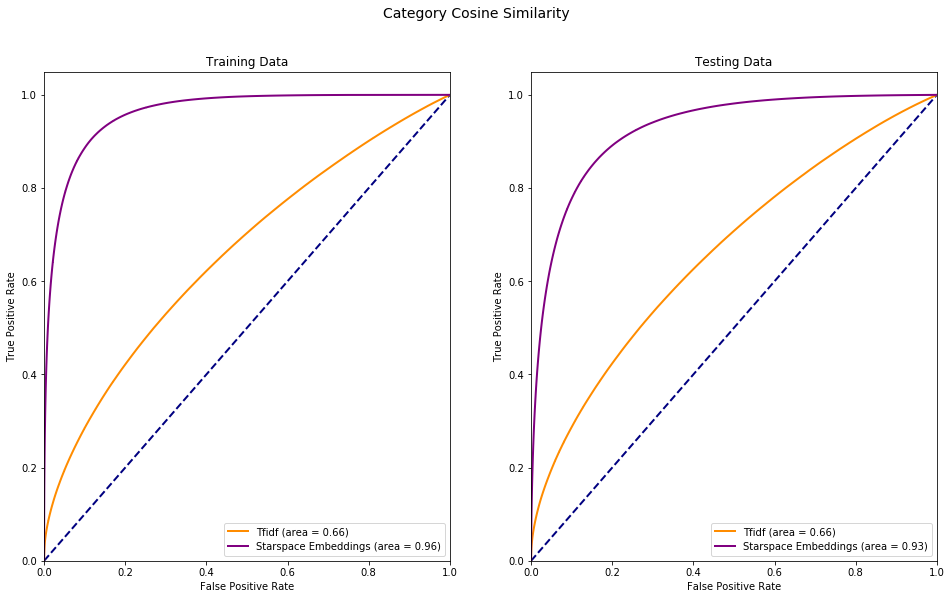

In [137]:
# Plot categorical similarity AUROC
labels = pd.factorize(Y_train)[0]
if labels.shape.__len__() == 1: labels = np.expand_dims(labels, 1)
    
not_nan_mask = np.squeeze(np.logical_and(np.expand_dims(labels, 0) >= 0, np.expand_dims(labels, 1) >= 0))
mask = np.squeeze(np.equal(np.expand_dims(labels, 0), np.expand_dims(labels, 1)))
mask = np.logical_and(mask, not_nan_mask)
related_mask = sparse.coo_matrix(np.tril(mask, -1))
unrelated_mask = sparse.coo_matrix(np.tril(np.logical_and(np.logical_not(mask), not_nan_mask), -1))

# Init plot
figsize=(16, 9)
fig = plt.figure(figsize=figsize)
plt.subplot(121)
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# AUROC
pairwise_similarity_metrics = tfidf_train_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Tfidf (area = %0.2f)' % auroc)

# AUROC
pairwise_similarity_metrics = train_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='purple', lw=lw, label='Starspace Embeddings (area = %0.2f)' % auroc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Training Data')

labels = pd.factorize(Y_validate)[0]
if labels.shape.__len__() == 1: labels = np.expand_dims(labels, 1)

not_nan_mask = np.squeeze(np.logical_and(np.expand_dims(labels, 0) >= 0, np.expand_dims(labels, 1) >= 0))
mask = np.squeeze(np.equal(np.expand_dims(labels, 0), np.expand_dims(labels, 1)))
mask = np.logical_and(mask, not_nan_mask)
related_mask = sparse.coo_matrix(np.tril(mask, -1))
unrelated_mask = sparse.coo_matrix(np.tril(np.logical_and(np.logical_not(mask), not_nan_mask), -1))

# Init 2nd plot
plt.subplot(122)
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# AUROC
pairwise_similarity_metrics = tfidf_validate_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Tfidf (area = %0.2f)' % auroc)

# AUROC
pairwise_similarity_metrics = validate_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='purple', lw=lw, label='Starspace Embeddings (area = %0.2f)' % auroc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Testing Data')

fig.suptitle("Category Cosine Similarity", fontsize=14)

Text(0.5, 0.98, 'Story Cosine Similarity')

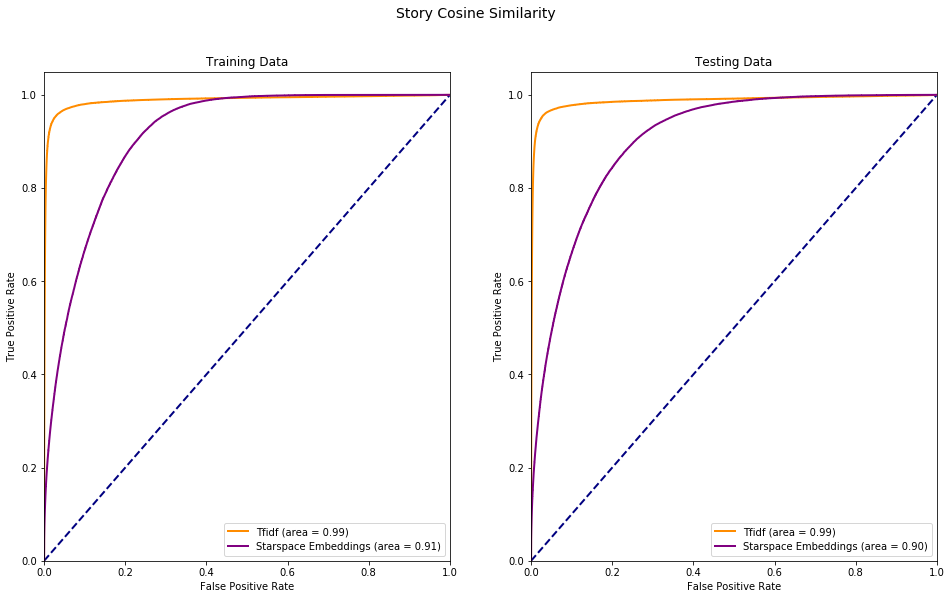

In [138]:
# Plot categorical similarity AUROC
labels = pd.factorize(article_contents.story.iloc[0:train_row])[0]
if labels.shape.__len__() == 1: labels = np.expand_dims(labels, 1)
    
not_nan_mask = np.squeeze(np.logical_and(np.expand_dims(labels, 0) >= 0, np.expand_dims(labels, 1) >= 0))
mask = np.squeeze(np.equal(np.expand_dims(labels, 0), np.expand_dims(labels, 1)))
mask = np.logical_and(mask, not_nan_mask)
related_mask = sparse.coo_matrix(np.tril(mask, -1))
unrelated_mask = sparse.coo_matrix(np.tril(np.logical_and(np.logical_not(mask), not_nan_mask), -1))

# Init plot
figsize=(16, 9)
fig = plt.figure(figsize=figsize)
plt.subplot(121)
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# AUROC
pairwise_similarity_metrics = tfidf_train_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Tfidf (area = %0.2f)' % auroc)

# AUROC
pairwise_similarity_metrics = train_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='purple', lw=lw, label='Starspace Embeddings (area = %0.2f)' % auroc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Training Data')

labels = pd.factorize(article_contents.story.iloc[train_row:train_row + validate_row])[0]
if labels.shape.__len__() == 1: labels = np.expand_dims(labels, 1)

not_nan_mask = np.squeeze(np.logical_and(np.expand_dims(labels, 0) >= 0, np.expand_dims(labels, 1) >= 0))
mask = np.squeeze(np.equal(np.expand_dims(labels, 0), np.expand_dims(labels, 1)))
mask = np.logical_and(mask, not_nan_mask)
related_mask = sparse.coo_matrix(np.tril(mask, -1))
unrelated_mask = sparse.coo_matrix(np.tril(np.logical_and(np.logical_not(mask), not_nan_mask), -1))

# Init 2nd plot
plt.subplot(122)
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# AUROC
pairwise_similarity_metrics = tfidf_validate_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Tfidf (area = %0.2f)' % auroc)

# AUROC
pairwise_similarity_metrics = validate_cosine_sim
related_data = pairwise_similarity_metrics[related_mask.row, related_mask.col]
unrelated_data = pairwise_similarity_metrics[unrelated_mask.row, unrelated_mask.col]
fpr, tpr, thresholds = roc_curve(['Related']*len(related_data) + ['Unrelated']*len(unrelated_data), list(related_data) + list(unrelated_data), pos_label='Related')
auroc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='purple', lw=lw, label='Starspace Embeddings (area = %0.2f)' % auroc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Testing Data')

fig.suptitle("Story Cosine Similarity", fontsize=14)